In [1]:
# load libraries
library(dplyr)
library("edgeR")
library(Matrix)
library(gplots)
library(RColorBrewer)
library(irlba)
library(proxy)
library(png)
library(tidyverse)
library(ComplexHeatmap)
library(here)
library(preprocessCore)
library(circlize)
`%ni%` <- Negate(`%in%`)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: limma


Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess



Attaching package: ‘proxy’


The following object is masked from ‘package:Matrix’:

    as.matrix


The following objects are masked from ‘package:stats’:

    as.dist, dist


The following object is masked from ‘package:base’:

    as.matrix


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0.9000     ✔ readr     2.1.4     
✔ ggplot2   3.4.3          ✔ stringr   1.5.0     
✔ lubridate 1.9.2          ✔ tibble    3.2.1     
✔ purrr     1.0.2          ✔ tidyr     1.3.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::expand() masks Matrix::expand()
✖ dplyr::filter() m

In [2]:
get_CPM_values <- function(input, meta, cell_annot_alot){
  
  meta_data <- read.delim(meta) %>% 
        rename(cell_type = !!sym(cell_annot_alot)) 
    
    
  raw_cpm_counts_all_genes <- read_delim(input, delim="\t", col_names = c("gene_name", "barcode", "accessability")) %>%
    dplyr::mutate(cellID = barcode)  %>%
    dplyr::mutate(geneID = gene_name)
    
  merged_meta_cpm_information <- left_join(meta_data, raw_cpm_counts_all_genes, by = c("cellID"))  %>%
    group_by(cell_type, geneID)  %>%
    summarise(counts = sum(accessability, na.rm = TRUE))

  ### Alt CPM Calc
  merged_meta_cpm_information_copied <- merged_meta_cpm_information
  catch <- merged_meta_cpm_information_copied  %>%
    group_by(cell_type) %>%
    group_map(~(cpm(.x$counts, log = FALSE, group = .f)), .keep = TRUE)  %>%
    unlist()

  caught_values <- as_tibble(catch)
  #see <- ungroup(merged_meta_cpm_information_copied)
  merged_meta_cpm_information_copied <- bind_cols(merged_meta_cpm_information_copied, caught_values)  %>% 
    rename(grouped_CPM = value)
    
    
  quantile_normalized_values <- merged_meta_cpm_information_copied %>% 
        group_by(cell_type) %>% 
        group_map(~(preprocessCore::normalize.quantiles(data.matrix(.x$grouped_CPM), copy = FALSE)), .keep = TRUE)  %>% 
        unlist()

    
    
  quantile_normalized <- as_tibble(quantile_normalized_values)  %>% 
        dplyr::rename("quant_norm_cpm" = value)


  quantile_normalized_data <- bind_cols(merged_meta_cpm_information_copied, quantile_normalized) %>% 
        group_by(geneID)
        #dplyr::mutate(Zscore = scale(quant_norm_cpm))



  return(quantile_normalized_data)
}



In [4]:
generate_matrix_for_heatmap <- function(cell_type_by_gene_by_quant_norm, markers) {
    
    
    mat <- cell_type_by_gene_by_quant_norm %>%
        dplyr::filter(cell_type %in% c("mesophyll", "bundle_sheath")) %>% 
        dplyr::filter(geneID %in% markers$geneID) %>% 
        left_join(., markers, by = c("geneID")) %>% 
        dplyr::ungroup() %>%   
        dplyr::select(cell_type, name, quant_norm_cpm) %>% 
        pivot_wider(names_from = cell_type, values_from = quant_norm_cpm) %>% 
        dplyr::rowwise() %>% 
        dplyr::mutate(log2_val = log2(bundle_sheath/mesophyll)) %>% 
        dplyr::select(name, log2_val) 
}

In [5]:
output_location <- "/home/jpm73279/data_copy_over/comparative_single_cell_imgs/figures/figure_2/heatmaps/"

In [6]:
os_gene_activity <- "/scratch/jpm73279/comparative_single_cell/04.marker_annotation/oryza_sativa/acc_metrics_leaf_clusering/oryza_sativa.gene_body_acc_leaf_clusering.counts.txt"
os_meta <- "/home/jpm73279/Mendieta_et_al_comparative_single_cell/metrics/annotations/os_annot/os.leaf_annotation.V1.meta.txt"

In [12]:
os_marker_genes <- read_delim("/home/jpm73279/genome_downloads/C4_markers/Os.c4_markers.bed",, col_names = c("chrom", "start", "stop", "geneID", "name", "type"))

Rows: 29 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): chrom, geneID, name, type
dbl (2): start, stop

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [13]:
os_cpm_values <- get_CPM_values(os_gene_activity, os_meta, "annotation_v1")

Rows: 102767261 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): gene_name, barcode
dbl (1): accessability

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'cell_type'. You can override using the
`.groups` argument.


In [11]:
head(os_marker_genes)

Chr1,25692716,25705090,LOC_Os01g45274,Os__CA_1,mesophyll
<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
Chr9,17567631,17572392,LOC_Os09g28910,Os__CA_2,mesophyll
Chr5,28617594,28621585,LOC_Os05g49880,Os__NADMDH_2,"mesophyll,bundle_sheath"
Chr10,12977396,12982478,LOC_Os10g25140,Os__AlaAT_1,bundle_sheath
Chr10,12967816,12974250,LOC_Os10g25130,Os__AlaAT_2,mesophyll
Chr7,25492716,25497544,LOC_Os07g42600,Os__AlaAT_3,mesophyll
Chr7,446618,451162,LOC_Os07g01760,Os__AlaAT_4,mesophyll


In [14]:
os_C4_matrix <- generate_matrix_for_heatmap(os_cpm_values, os_marker_genes)
os_C4_matrix.df <- data.frame(os_C4_matrix, row.names = 1)

In [15]:
# Function definition
filter_tribble_by_name <- function(data, names) {
  updated <- data %>%
    filter(name %in% names)
    
    updated <- data.frame(updated, row.names = 1)
    return(updated)
}


# Generate Core C4 Gene Heatmaps

In [16]:
col_fun <- colorRamp2(c(-2, 0, 2), c("red", "white", "blue"))


generate_split_heatmap <- function(log2matrix, df_marker_type) {
    
     updated <- log2matrix %>%
        filter(name %in% df_marker_type$name) %>% 
        left_join(.,df_marker_type, by = c("name")) %>% 
        dplyr::group_by(cell_type) %>% 
        dplyr::arrange(desc(log2_val), .by_group = TRUE) %>% 
        mutate(name = str_replace_all(name, "_ortho_count_", "_"))


    return(updated)
    
}

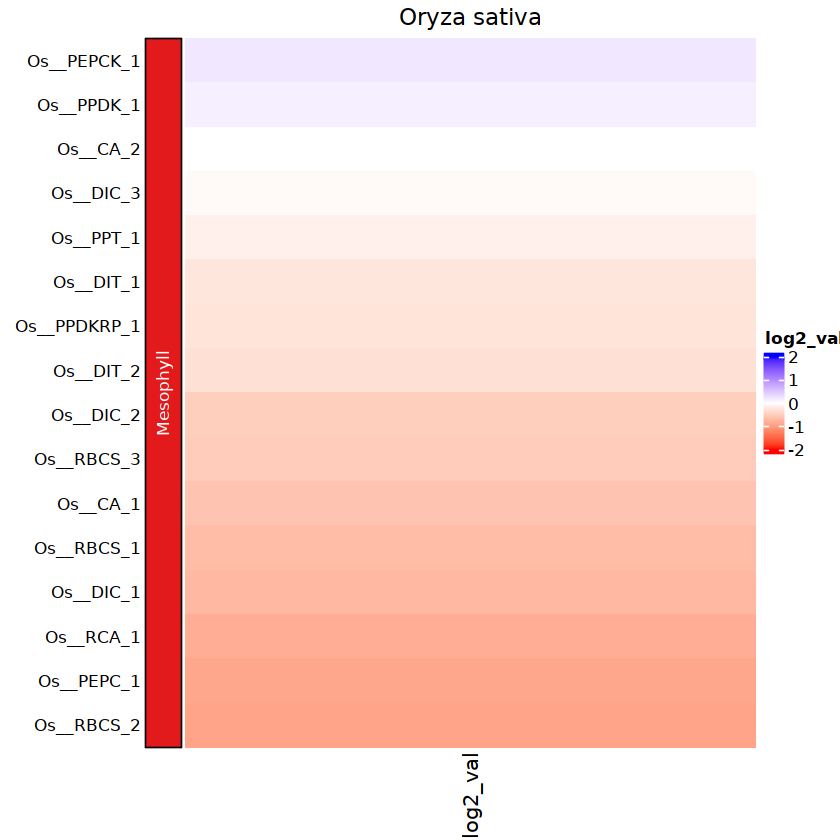

In [20]:
os_genes <- data.frame(
  name = c("Os__CA_1", "Os__CA_2", "Os__DIC_1", "Os__DIC_2", "Os__DIC_3",
           "Os__DIT_1", "Os__DIT_2", "Os__PEPC_1", "Os__PEPCK_1", "Os__PPDK_1",
           "Os__PPDKRP_1", "Os__PPT_1", "Os__RBCS_1", "Os__RBCS_2", "Os__RBCS_3", 
           "Os__RCA_1"),
  cell_type = rep("Mesophyll", 16)
)

os_data_merged <- generate_split_heatmap(os_C4_matrix ,os_genes)
os_data_merged <- os_data_merged %>%  
    dplyr::mutate(name = case_when(name == "Osppc4" ~ "PEPC",
                                   TRUE ~ name))


os_data_generate_matrix <- as.matrix(os_data_merged[,"log2_val"])
rownames(os_data_generate_matrix) <- os_data_merged$name

# create heatmap
os_heatmap <- Heatmap(os_data_generate_matrix, name = "log2_val",
                   col = col_fun,
                   row_names_gp = gpar(fontsize = 10),
                   split = os_data_merged$cell_type,
                    row_names_side = "left",
                   show_row_names = TRUE,
                   cluster_rows = FALSE,
                    row_title = NULL,

                   #row_title = "Gene",
                   row_title_side = "left",
                    left_annotation = rowAnnotation(foo = anno_block(gp = gpar(fill = c("#E31A1C")),
                        labels = unique(os_data_merged$cell_type), 
                        labels_gp = gpar(col = "white", fontsize = 10))),  
                     column_title = "Oryza sativa",
                   row_title_gp = gpar(fontsize = 14))


os_heatmap

# Generate heatmap for Subtypes

In [25]:
os_annot_markers_subtype

name,cell_type
<chr>,<fct>
NHD1__NHD2,"Mesophyll, Bundle Sheath"
BASS,"Mesophyll, Bundle Sheath"
DIT1,"Mesophyll, Bundle Sheath"
DIT2,"Mesophyll, Bundle Sheath"
NAD-MDH12,"Mesophyll, Bundle Sheath"
NAD-ME_1__NAD-ME_2,Mesophyll
NADP-MDH_1__NADP-MDH_2,Mesophyll
NADP_MDH,Mesophyll
AlaAT1,Mesophyll


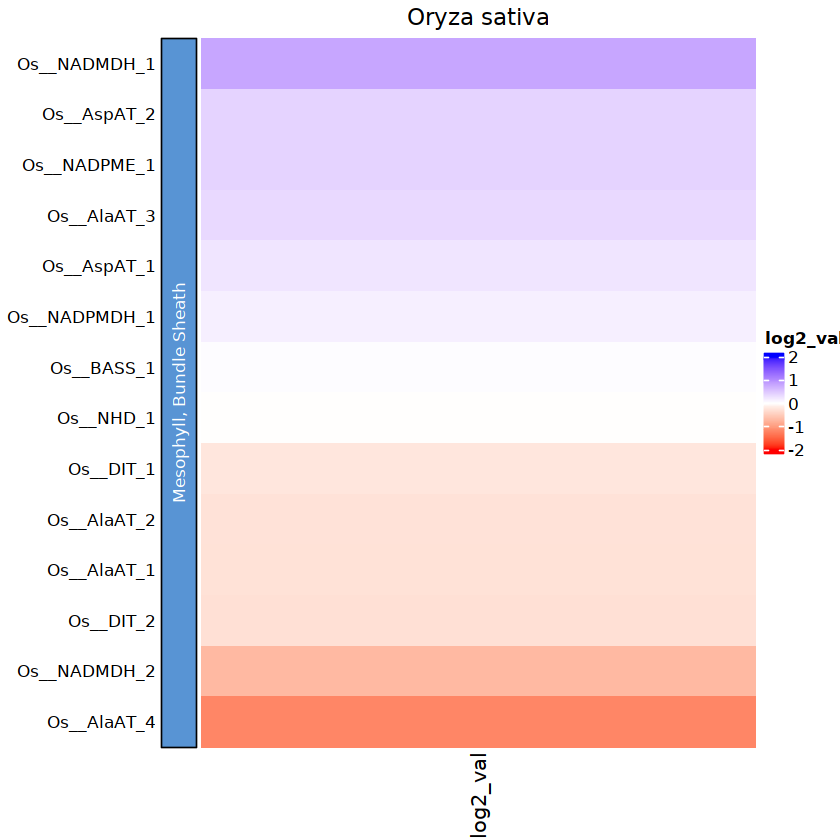

In [19]:

os_annot_markers_subtype <- data.frame(
  name = c("Os__NADMDH_2", "Os__AlaAT_1", "Os__AlaAT_2", "Os__AlaAT_3", "Os__AlaAT_4",
           "Os__AspAT_1", "Os__AspAT_2", "Os__BASS_1", "Os__DIT_1", "Os__DIT_2",
           "Os__NADPMDH_1", "Os__NADPME_1", "Os__NHD_1", "Os__NADMDH_1"),
  cell_type = rep("Mesophyll, Bundle Sheath", 14)
)

# Assuming your data frame is named df
os_annot_markers_subtype$cell_type <- as.factor(os_annot_markers_subtype$cell_type)
os_annot_markers_subtype$cell_type <- factor(os_annot_markers_subtype$cell_type, levels = c("Mesophyll, Bundle Sheath", "Mesophyll"))    
os_annot_markers_subtype <-  os_annot_markers_subtype %>% 
    arrange(cell_type)


os_data_merged_subtype <- generate_split_heatmap(os_C4_matrix, os_annot_markers_subtype)
os_generate_matrix_subtype <- as.matrix(os_data_merged_subtype[,"log2_val"])
rownames(os_generate_matrix_subtype) <- os_data_merged_subtype$name

# create heatmap
os_heatmap_subtype <- Heatmap(os_generate_matrix_subtype, name = "log2_val",
                   col = col_fun,
                   row_names_gp = gpar(fontsize = 10),
                   split = factor(os_annot_markers_subtype$cell_type, levels = c("Mesophyll, Bundle Sheath", "Mesophyll")),
                    row_names_side = "left",
                   show_row_names = TRUE,
                   cluster_rows = FALSE,
                   #row_title = "Gene",
                   row_title = NULL,
                   row_title_side = "left",
                    left_annotation = rowAnnotation(foo = anno_block(gp = gpar(fill = c("#5894D4", "#E31A1C")),
                        labels = unique((os_annot_markers_subtype$cell_type)), 
                        labels_gp = gpar(col = "white", fontsize = 10))),  
                     column_title = "Oryza sativa",
                   row_title_gp = gpar(fontsize = 14))

os_heatmap_subtype
#draw(heatmap)

In [21]:
output_function <- function(output_place, heatmap, name) {
    file_name <- paste0(output_place, name)
    pdf(file = file_name, height = 6, width = 4)
    draw(heatmap)
    dev.off()
}

In [22]:
output_function(output_location, os_heatmap, "os_core_c4_genes.pdf")
output_function(output_location, os_heatmap_subtype, "os_variable_c4_genes.pdf")

png 
  2

png 
  2